# Narrow band parameter estimation

The narrow-band parameter estimation is carried out using the `fit_color.py` script instead of a notebook. The script was run for the masked and unmasked datasets with parameters

```
./fit_color.py --n-walkers 300 --n-threads 3 --do-mc --run-name nomask --de-n-iterations 600 --mc-n-iterations 5000 --mc-n-runs 15 --mc-thin 50 --lc-name "final/nb_nomask"
```

```
./fit_color.py --n-walkers 300 --n-threads 3 --do-mc --run-name masked --de-n-iterations 600 --mc-n-iterations 5000 --mc-n-runs 15 --mc-thin 50 --lc-name "final/nb_masked"
```

These settings were chosen after a several test runs.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import math as mt
import pandas as pd
import seaborn as sb

from IPython.html.widgets import Text, IntProgress, HBox, VBox, HTML
from pandas import HDFStore
from emcee import EnsembleSampler
from pyde.de import DiffEvol
from pytransit import MandelAgol as MA

from ldtk import LDPSetCreator
from exotk.priors import UP, NP, PriorSet
from exotk.utils.orbits import as_from_rhop
from exotk.utils.likelihood import ll_normal_es

from core import *

for f in pb_filters_nb:
    f.name = 'a'

pb_filter_bb.name = 'white'

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Create a wrapper class for the parameter estimation 

We have two versions of the white light curve: one without masking of the spectrum and one with masking. 

In [3]:
class LPFunction(object):
    def __init__(self, time, flux, airmass, nthreads=2):
        self.tm = MA(interpolate=True, klims=(0.15,0.20), nthr=nthreads, nk=512) 
        self.nthr = nthreads

        self.time     = array(time)
        self.flux_o   = array(flux)
        self.airmass  = array(airmass)
        self.npt      = self.flux_o.shape[0]
        self.npb      = self.flux_o.shape[1]
        self._w_bl    = ones_like(flux)
        self._w_ld    = zeros(2*self.npb)
        
        sc = LDPSetCreator(teff=(5650,35),logg=(4.58,0.015),z=(-0.19,0.08), filters=pb_filters_nb)
        self.lds = sc.create_profiles(500)
        self.lds.resample_linear_z()
        
        self.priors = [UP(  0.605,   0.615,   'tc'),  ##  0  - Transit centre
                       NP(  1.306,   1e-7,     'p'),  ##  1  - Period
                       UP(  1.000,   3.00,   'rho'),  ##  2  - Stellar density
                       UP(  0.000,   0.99,     'b')]  ##  3  - Impact parameter
        
        for ipb in range(self.npb):
            self.priors.extend([
                       UP( .15**2, .20**2,    'k2'),  ##  4 + 6*i  - planet-star area ratio
                       UP(   1e-4,  10e-4,     'e'),  ##  5 + 6*i  - White noise std
                       NP(    1.0,   0.01,     'c'),  ##  6 + 6*i  - Baseline constant
                       NP(    0.0,   0.01,     'x'),  ##  7 + 6*i  - Residual extinction coefficient
                       UP(   -1.0,    1.0,     'u'),  ##  8 + 6*i  - limb darkening u
                       UP(   -1.0,    1.0,     'v')]) ##  9 + 6*i  - limb darkening v
            
        self.ps = PriorSet(self.priors)
        
        
    def compute_baseline(self, pv):
        return pv[6::6]*np.exp(pv[7::6,]*self.airmass[:,newaxis])
    
    
    def compute_transit(self, pv):
        _a  = as_from_rhop(pv[2], pv[1])
        _i  = mt.acos(pv[3]/_a)
        _k  = sqrt(pv[4::6])
        self._w_ld[0::2] = pv[8::6]
        self._w_ld[1::2] = pv[9::6]                 
        return self.tm.evaluate(self.time, _k, self._w_ld, pv[0], pv[1], _a, _i)
    
    
    def compute_lc_model(self, pv):
        return self.compute_baseline(pv)*self.compute_transit(pv)


    def log_posterior(self, pv):
        if any(pv < self.ps.pmins) or any(pv>self.ps.pmaxs):
            return -inf
        
        flux_m = self.compute_lc_model(pv)
        lnlike_lc = sum([ll_normal_es(self.flux_o[:,ipb], flux_m[:,ipb], pv[5+6*ipb]) for ipb in range(self.npb)])
        lnlike_ld = self.lds.lnlike_qd(self._w_ld)                
        return self.ps.c_log_prior(pv) + lnlike_lc + lnlike_ld


    def __call__(self, pv):
        return self.log_posterior(pv)


In [4]:
class PE(object):
    def __init__(self, wfname, n_walkers=100, n_threads=4):
        df_aux = pd.read_hdf('results/light_curves.h5', 'aux')
        df_lc  = pd.read_hdf('results/light_curves.h5', wfname)
        msk = array(df_aux.bad_mask, dtype=np.bool)
        
        self.lpf = LPFunction(array(df_aux.mjd-56846+0.5)[msk], array(df_lc)[msk,:], df_aux.airmass[msk], n_threads)
        self.de = DiffEvol(self.lpf, self.lpf.ps.bounds, n_walkers, maximize=True, C=0.85, F=0.25)
        self.sampler = EnsembleSampler(self.de.n_pop, self.lpf.ps.ndim, self.lpf) 
                
        qc = self.lpf.lds.coeffs_qd()[0]
        for ipb in range(self.lpf.npb):
            self.de._population[:,8+6*ipb] = normal(qc[ipb,0], 0.05, size=n_walkers) 
            self.de._population[:,9+6*ipb] = normal(qc[ipb,1], 0.05, size=n_walkers)
                  
            
    def run_de(self, n_iter=250):
        wp = IntProgress(value=0, max=n_iter)
        wh = HTML(value='inf')
        wb = VBox(children=[wp,wh])
        display(wb)
        for i, p in enumerate(self.de(n_iter)):
            if i%25 == 0:
                wp.value += 25
                wh.value = 'DE maximum log posterior {:10.3f}'.format(-self.de.minimum_value)
            
            
    def run_mcmc(self, n_iter=2500, thin=50):
        pbar = IntProgress(max=n_iter)
        display(pbar)
        for i, c in enumerate(self.sampler.sample(self.de.population, iterations=n_iter, thin=thin)):
            if i%50 == 0:
                pbar.value += 50
                
                
    def create_dataframe(self, burn=0, thin=1):
        self.df = pd.DataFrame(self.fc(burn,thin), columns=self.lpf.ps.names)
        self.df['k'] = sqrt(self.df['k2'])
        return self.df     
                
        
    def fc(self, burn=0, thin=1):
        return self.chain[:,burn::thin,:].reshape([-1, self.chain.shape[2]])

    
    @property
    def chain(self):
        return self.sampler.chain

## Run the unmasked LC analysis 

In [5]:
pe_n = PE('final/nb_nomask', n_walkers=300)

In [32]:
pe_n.run_de(400)

(array([  4.,   7.,  13.,  30.,  50.,  76.,  57.,  40.,  15.,   8.]),
 array([-28293.01889269, -28292.8360409 , -28292.65318911, -28292.47033733,
        -28292.28748554, -28292.10463375, -28291.92178196, -28291.73893017,
        -28291.55607838, -28291.37322659, -28291.1903748 ]),
 <a list of 10 Patch objects>)

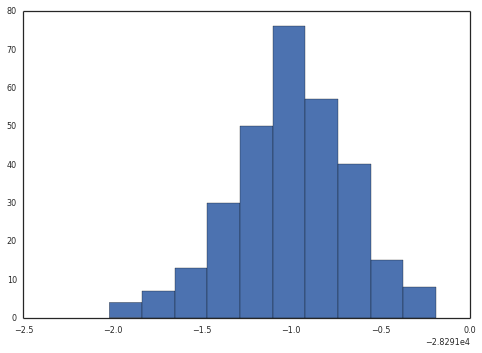

In [33]:
hist(pe_n.de._fitness)

In [45]:
pv0 = pe_n.chain[:,-1,:].copy()

In [46]:
pe_n.sampler.reset()

In [47]:
pe_n.de._population[:] = pv0

In [ ]:
pe_n.run_mcmc(15000)

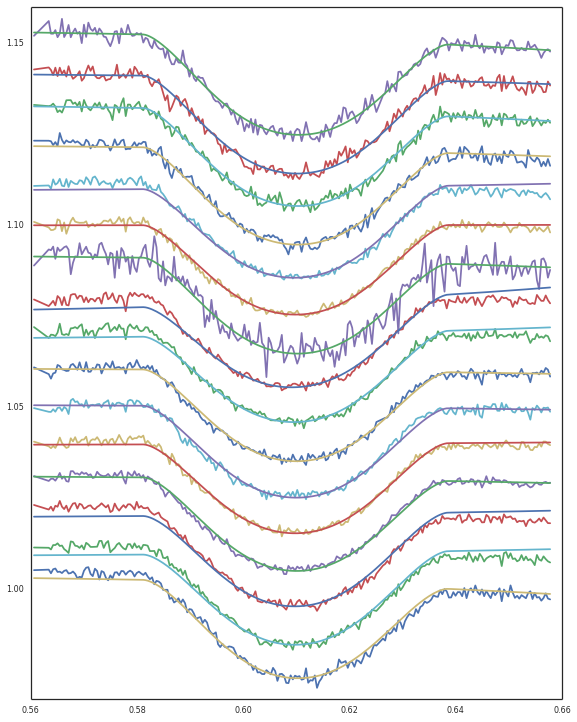

In [34]:
fig,ax = subplots(1,1,figsize=(8,10))
flux_m = pe_n.lpf.compute_lc_model(pe_n.de.minimum_location)
plot(pe_n.lpf.time, 1e-2*arange(16)+pe_n.lpf.flux_o);
plot(pe_n.lpf.time, 1e-2*arange(16)+flux_m);
ylim(0.97,1.16)
fig.tight_layout()

In [48]:
pe_n.run_mcmc(5000)

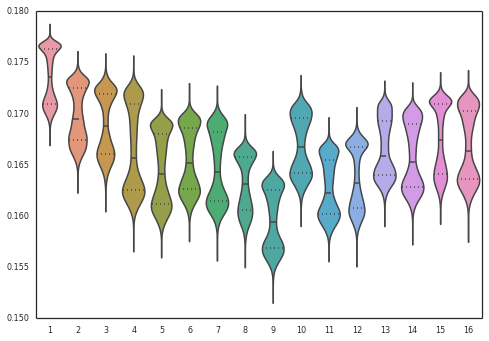

In [49]:

sb.violinplot(sqrt(pe_n.chain[:,:,4::6]).reshape([-1,16]))

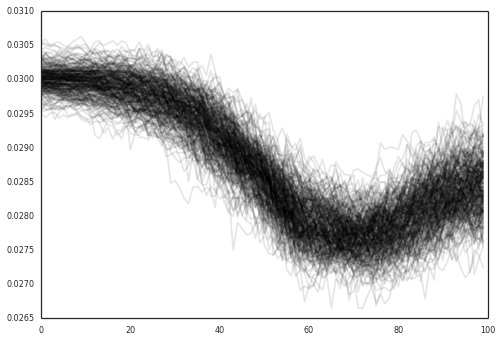

In [51]:
plot(pe_n.chain[:,:,4+6].T, 'k', alpha=0.1);

## Run the masked LC analysis 

In [8]:
pe_m = PE('final/bb_masked')
pe_m.run_de(300)
pe_m.run_mcmc()

## Create and save the dataframes

In [9]:
dfn = pe_n.create_dataframe(10)
#dfm = pe_m.create_dataframe(10)

In [10]:
hdf = HDFStore(join('results','pe.hdf'))
hdf.put('narrow_band/white_noise/nomask', dfn, format='table', data_columns=True)
hdf.put('narrow_band/white_noise/masked', dfm, format='table', data_columns=True)
hdf.close()

## Plots 

In [17]:
def get_range(p):
    pn = percentile(dfn[p], [0.25,99.75])
    pm = percentile(dfm[p], [0.25,99.75])
    return [min(pn[0],pm[0]),max(pn[1],pm[1])]

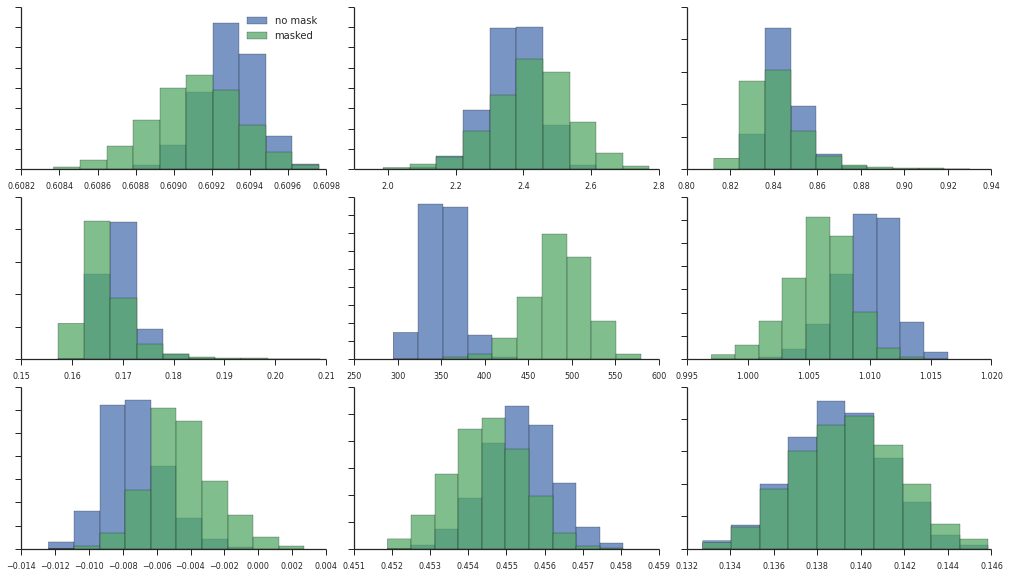

In [18]:
dfn['e_ppm'] = 1e6*dfn.e
dfm['e_ppm'] = 1e6*dfm.e

pars = 'tc rho b k e_ppm c x u v'.split()
cp = sb.color_palette()

with sb.axes_style('ticks'):
    fig,axs = subplots(3,3,figsize=(14,8))
    for i,p in enumerate(pars):
        rng = get_range(p)
        dfn[p].hist(ax=axs.flat[i], fc=cp[0], range=rng, label='no mask', grid=False, alpha=0.75)
        dfm[p].hist(ax=axs.flat[i], fc=cp[1], range=rng, label='masked', grid=False, alpha=0.75)
        setp(axs.flat[i].get_yticklabels(), visible=False)
    axs.flat[0].legend()
    sb.despine(fig)
    fig.tight_layout()

---
<center> &copy; 2015 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>